# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

The file `test_simple.py` shows a more complete version of this code, which additionally:
- Can run on GPU or CPU (this notebook only runs on CPU)
- Can predict for a whole folder of images, not just a single image
- Saves predictions to `.npy` files and disparity images.

In [1]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist

## Setting up network and loading weights

In [8]:
model_name = "mono_640x192"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

## Loading the test image and preprocessing

In [9]:
image_path = "assets/test_image.jpg"

input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

## Prediction using the PyTorch model

In [10]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]
print(disp)

tensor([[[[0.0859, 0.0851, 0.0850,  ..., 0.0979, 0.0982, 0.0991],
          [0.0857, 0.0850, 0.0850,  ..., 0.0982, 0.0983, 0.0994],
          [0.0858, 0.0852, 0.0849,  ..., 0.0977, 0.0982, 0.0994],
          ...,
          [0.5460, 0.5408, 0.5384,  ..., 0.5413, 0.5418, 0.5453],
          [0.5523, 0.5475, 0.5458,  ..., 0.5484, 0.5492, 0.5527],
          [0.5569, 0.5526, 0.5513,  ..., 0.5539, 0.5548, 0.5584]]]])


## Plotting

[[0.08585393 0.08509481 0.08502618 ... 0.09790478 0.09818974 0.09914456]
 [0.08572225 0.08504282 0.08502986 ... 0.09815393 0.0983025  0.099342  ]
 [0.08573417 0.08512246 0.0849825  ... 0.09796372 0.09823822 0.09942093]
 ...
 [0.5488725  0.543813   0.5417924  ... 0.54454374 0.545197   0.54865617]
 [0.5535987  0.5488665  0.54729164 ... 0.5499109  0.55074424 0.55425656]
 [0.5569234  0.5525984  0.55122876 ... 0.55392385 0.5547871  0.5583703 ]]


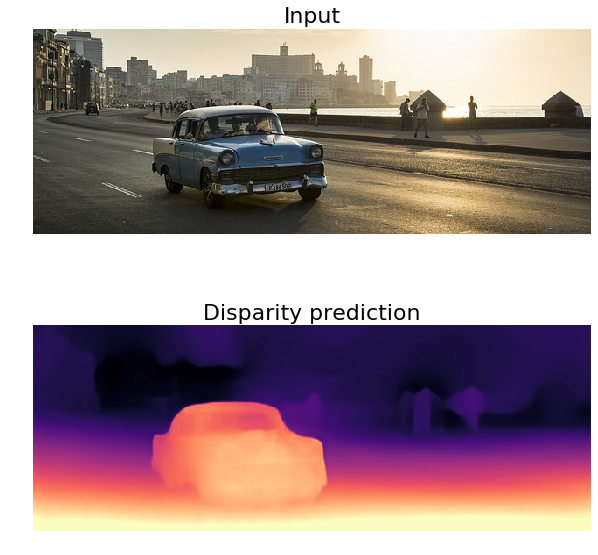

In [11]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)
print(disp_resized_np)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');